In [2]:
# Importing the necessary libraries
import torch
from torch import nn

import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
transform = transforms.Compose(
    [ transforms.Resize((224,224)),
      #transforms.Augmix(), #for data agumentation
      transforms.CenterCrop(224),
      transforms.ToTensor(), # this to convert the images to 4D matrix (B,C,H,W)
      #transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) ]
      transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))] # this require the mean and standard deviation
)

#12/12/23
train_dir = '/content/drive/MyDrive/Covid19-dataset/train'
test_dir = '/content/drive/MyDrive/Covid19-dataset/test'

train_data = datasets.ImageFolder(root = train_dir,transform = transform)

test_data = datasets.ImageFolder(root = test_dir,transform = transform)


In [7]:
class_names = train_data.classes
train_data.classes

['Covid', 'Normal', 'Viral Pneumonia']

In [8]:
from torch.utils.data import DataLoader
BATCH_SIZE = 4
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE, shuffle=False)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x788b9cfe8c10>, <torch.utils.data.dataloader.DataLoader object at 0x788b9cfe9ff0>)
Length of train dataloader: 63 batches of 4
Length of test dataloader: 17 batches of 4


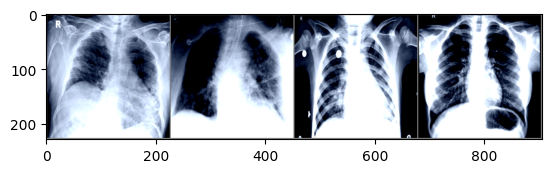

Covid Covid Viral Pneumonia Normal


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize our dataset
def show_image(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
show_image(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [67]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 6, 5)  # Input channels changed to 1
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Pooling layers
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        # The sizing here assumes that the input image size will be reduced
        # to 5x5 after two convolutions and two poolings
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 10)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolution 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Convolution 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Flattening the tensor for the fully connected layer
        x = x.view(-1, 16 * 53 * 53)

        # Fully connected layer 1
        x = self.fc1(x)
        x = self.relu(x)

        # Fully connected layer 2 (Output layer)
        x = self.fc2(x)
        # No softmax here since it's handled by nn.CrossEntropyLoss during training
        return x


In [68]:
model = CNNModel()

In [69]:
model.train()

CNNModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (relu): ReLU()
)

In [70]:
!pip install torchinfo

In [71]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            456
├─Conv2d: 1-2                            2,416
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            5,393,400
├─Linear: 1-5                            1,210
├─ReLU: 1-6                              --
Total params: 5,397,482
Trainable params: 5,397,482
Non-trainable params: 0

In [74]:
#cross-entropy
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)#sgd:stochastic gradiant descent


In [75]:
model.to('cuda')

CNNModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
  (relu): ReLU()
)

In [76]:
import time
from tqdm.auto import tqdm

def train_and_validate(model, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device='cuda'):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param train_dataloader: DataLoader for training data
        :param test_dataloader: DataLoader for test/validation data
        :param epochs: Number of epochs (default=25)
        :param device: Device to perform computations ('cuda' or 'cpu')

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)


        # Find average training loss and training accuracy
        avg_train_loss = train_loss / len(train_dataloader.dataset)
        avg_train_acc = train_acc / len(train_dataloader.dataset)

        # Find average validation loss and training accuracy
        avg_test_loss = valid_loss / len(test_dataloader.dataset)
        avg_test_acc = valid_acc / len(test_dataloader.dataset)

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc * 100, avg_test_loss, avg_test_acc * 100, epoch_end - epoch_start))

        # Save if the model has best accuracy till now
        if avg_test_acc > best_acc:
            best_acc = avg_test_acc
            best_model = model
            torch.save(best_model, 'best_model.pt')

    return best_model, history

In [77]:
import torch
if torch.cuda.is_available():
    print("CUDA is available. You can use GPU.")
else:
    print("CUDA is not available. You can only use CPU.")


CUDA is available. You can use GPU.


In [78]:
num_epochs = 10
trained_model, history = train_and_validate(model,loss_fn,optimizer,train_dataloader,test_dataloader,num_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10
Epoch : 000, Training: Loss: 0.9133, Accuracy: 72.1116%, 
		Validation : Loss : 0.6344, Accuracy: 78.7879%, Time: 43.3404s
Epoch: 2/10
Epoch : 001, Training: Loss: 0.3122, Accuracy: 88.8446%, 
		Validation : Loss : 0.8276, Accuracy: 69.6970%, Time: 12.0598s
Epoch: 3/10
Epoch : 002, Training: Loss: 0.2823, Accuracy: 92.4303%, 
		Validation : Loss : 0.4244, Accuracy: 84.8485%, Time: 12.0812s
Epoch: 4/10
Epoch : 003, Training: Loss: 0.1611, Accuracy: 94.4223%, 
		Validation : Loss : 0.6565, Accuracy: 71.2121%, Time: 13.6262s
Epoch: 5/10
Epoch : 004, Training: Loss: 0.2019, Accuracy: 90.8367%, 
		Validation : Loss : 0.3921, Accuracy: 81.8182%, Time: 12.0853s
Epoch: 6/10
Epoch : 005, Training: Loss: 0.1168, Accuracy: 95.6175%, 
		Validation : Loss : 0.5334, Accuracy: 78.7879%, Time: 11.5781s
Epoch: 7/10
Epoch : 006, Training: Loss: 0.0523, Accuracy: 98.4064%, 
		Validation : Loss : 0.5076, Accuracy: 86.3636%, Time: 11.1890s
Epoch: 8/10
Epoch : 007, Training: Loss: 0.0389, Accura

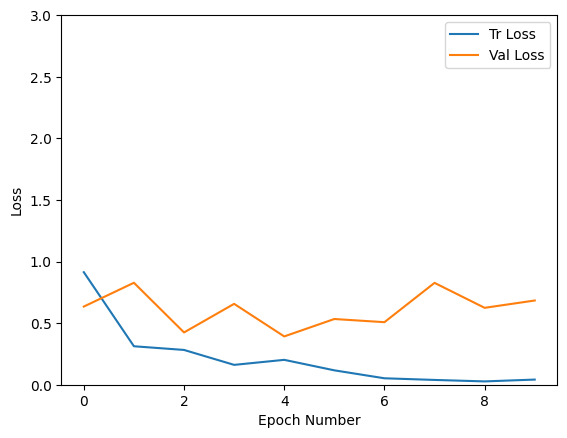

In [79]:
#Analyze the loss curve

def plot_loss(history):
  history = np.array(history)
  plt.plot(history[:,0:2])
  plt.legend(['Tr Loss', 'Val Loss'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Loss')
  plt.ylim(0,3)
  # plt.savefig('cifar10_loss_curve.png')
  plt.show()

plot_loss(history)

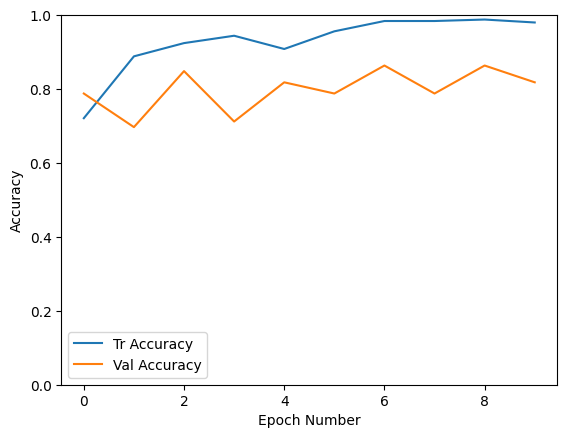

In [80]:
def plot_accuracy(history):
  history = np.array(history)
  plt.plot(history[:,2:4])
  plt.legend(['Tr Accuracy', 'Val Accuracy'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Accuracy')
  plt.ylim(0,1)
  # plt.savefig('cifar10_accuracy_curve.png')
  plt.show()

plot_accuracy(history)

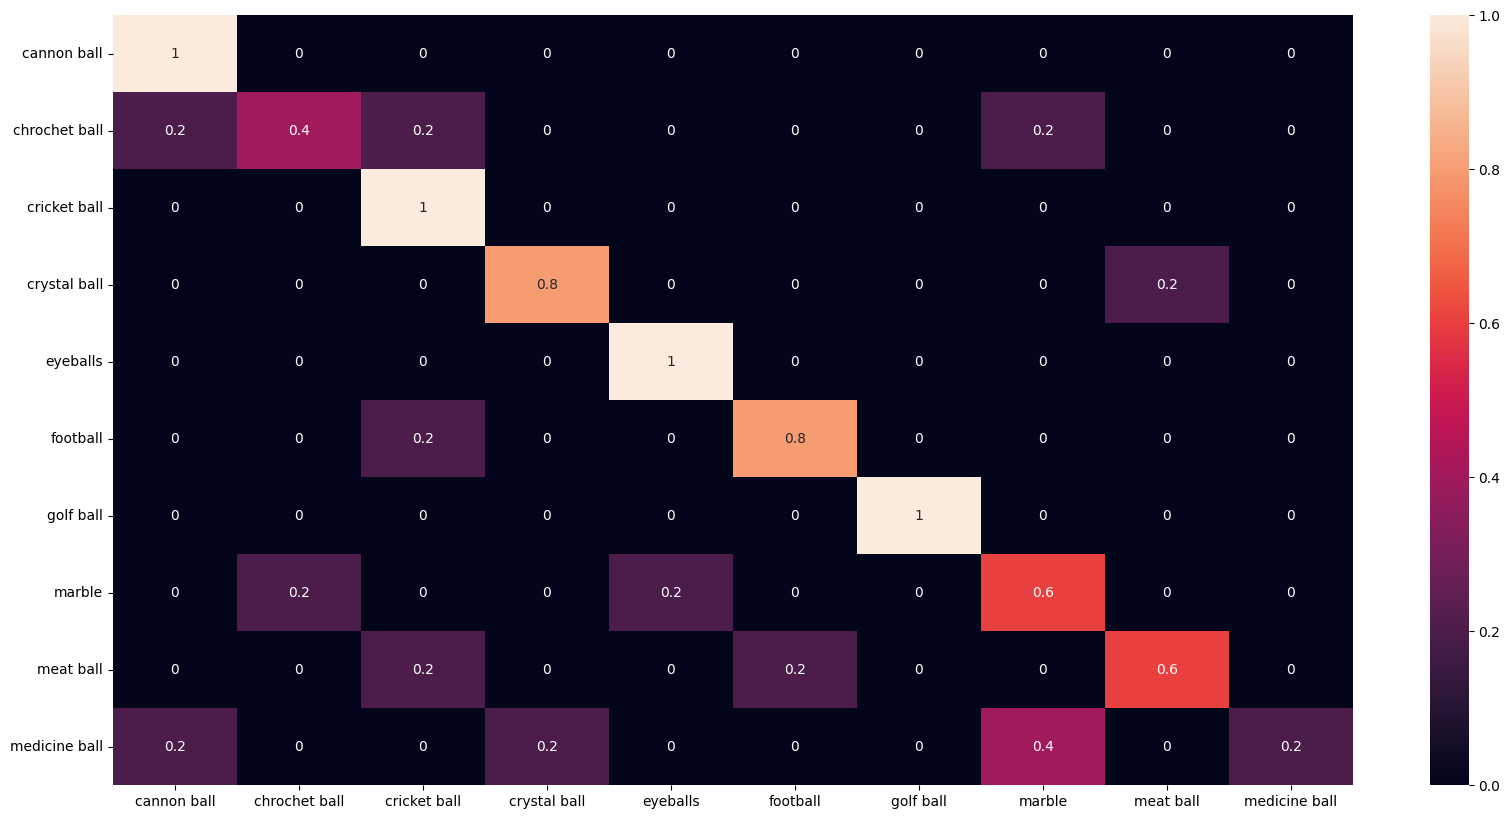

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def plot_confusionMatrix(model, test_dataloader):

  y_pred = []
  y_true = []

  model.to('cpu')

  # iterate over test data
  for inputs, labels in test_dataloader:
          output = model(inputs) # Feed Network

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction

          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in class_names],
                      columns = [i for i in class_names])
  plt.figure(figsize = (20,10))
  sn.heatmap(df_cm, annot=True)
  # plt.savefig('output.png')

plot_confusionMatrix(model, test_dataloader)